In [1]:
# Import Important Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load dataset
data_path = r"C:\Users\HP\Downloads\PRAICP-1003-AirTempTS\Data\surface-air-temperature-monthly-mean.csv"  

# Read CSV without parsing dates
df = pd.read_csv(data_path)

# Print column names
print(df.columns)



Index(['month', 'mean_temp'], dtype='object')


In [3]:
# Read CSV with date parsing
df = pd.read_csv(data_path, parse_dates=['month'])

# Set 'month' column as index (useful for time series modeling)
df.set_index('month', inplace=True)

print(df.info())  
print(df.head())  

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 462 entries, 1982-01-01 to 2020-06-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mean_temp  462 non-null    float64
dtypes: float64(1)
memory usage: 7.2 KB
None
            mean_temp
month                
1982-01-01       25.9
1982-02-01       27.1
1982-03-01       27.2
1982-04-01       27.0
1982-05-01       28.0


mean_temp    0
dtype: int64
        mean_temp
count  462.000000
mean    27.665152
std      0.808186
min     25.400000
25%     27.100000
50%     27.700000
75%     28.300000
max     29.500000


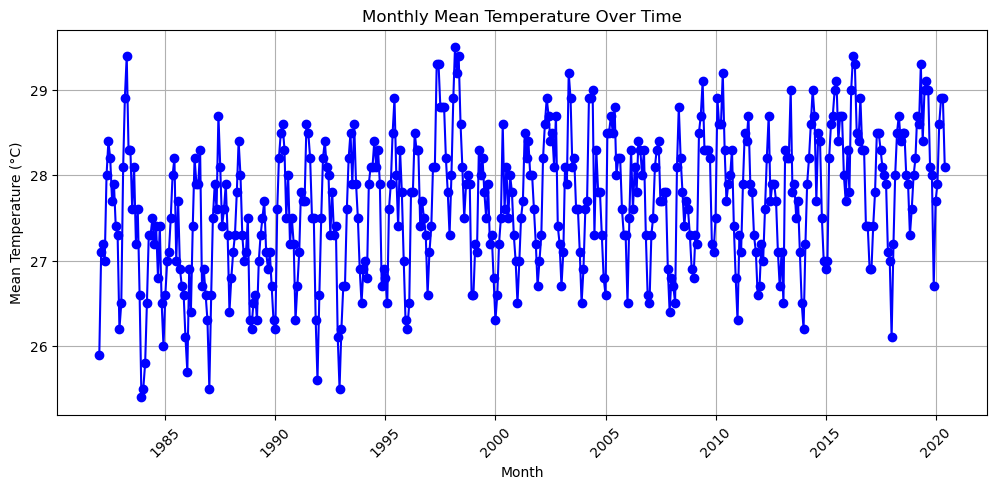

In [4]:
# Check missing values
print(df.isnull().sum())

# Summary statistics
print(df.describe())


# Plot data
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['mean_temp'], marker='o', linestyle='-', color='b')
plt.title("Monthly Mean Temperature Over Time")
plt.xlabel("Month")
plt.ylabel("Mean Temperature (°C)")
plt.grid()
plt.xticks(rotation=45)  
plt.show()


In [5]:
# Convert dataset to supervised learning format
def create_features(dataset, look_back=12):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i+look_back])
        y.append(dataset[i+look_back])
    return np.array(X), np.array(y)

# Extract values and normalize them
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['mean_temp']])

# Create training dataset
look_back = 12  # Using past 12 months
X, y = create_features(scaled_data, look_back)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape for LSTM input (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [6]:
# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
23/23 [==============================] - 11s 103ms/step - loss: 0.1253 - val_loss: 0.0411
Epoch 2/50
23/23 [==============================] - 0s 21ms/step - loss: 0.0416 - val_loss: 0.0362
Epoch 3/50
23/23 [==============================] - 0s 22ms/step - loss: 0.0368 - val_loss: 0.0350
Epoch 4/50
23/23 [==============================] - 0s 22ms/step - loss: 0.0363 - val_loss: 0.0327
Epoch 5/50
23/23 [==============================] - 0s 22ms/step - loss: 0.0364 - val_loss: 0.0335
Epoch 6/50
23/23 [==============================] - 1s 22ms/step - loss: 0.0355 - val_loss: 0.0335
Epoch 7/50
23/23 [==============================] - 1s 22ms/step - loss: 0.0363 - val_loss: 0.0304
Epoch 8/50
23/23 [==============================] - 0s 21ms/step - loss: 0.0370 - val_loss: 0.0317
Epoch 9/50
23/23 [==============================] - 0s 21ms/step - loss: 0.0346 - val_loss: 0.0356
Epoch 10/50
23/23 [==============================] - 0s 21ms/step - loss: 0.0342 - val_loss: 0.0313
Epoch 1

3/3 [==============================] - 2s 10ms/step
Mean Absolute Error (MAE): 0.36
Root Mean Squared Error (RMSE): 0.45


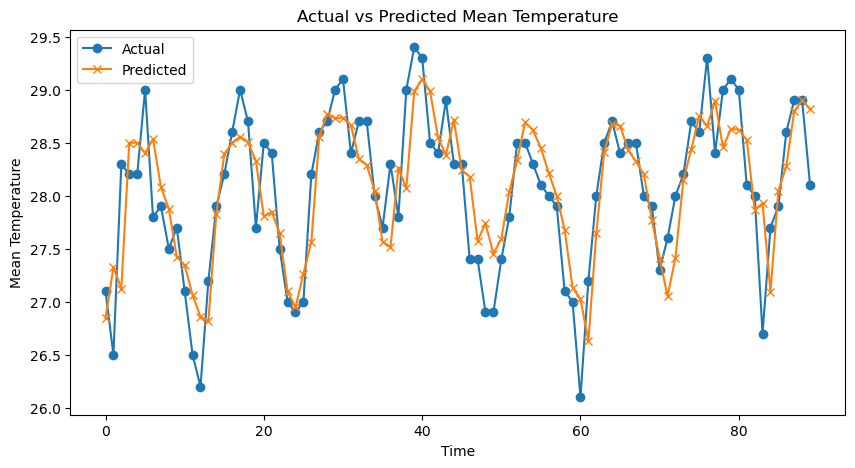

In [7]:
# Predict on test data
y_pred = model.predict(X_test)

# Inverse transform the predictions
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate performance
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label="Actual", marker='o')
plt.plot(y_pred_inv, label="Predicted", marker='x')
plt.title("Actual vs Predicted Mean Temperature")
plt.xlabel("Time")
plt.ylabel("Mean Temperature")
plt.legend()
plt.show()


In [13]:
model.save(r"C:\Users\HP\Downloads\Air Temp TS")
print("Model saved successfully")

INFO:tensorflow:Assets written to: C:\Users\HP\Downloads\Air Temp TS\assets


INFO:tensorflow:Assets written to: C:\Users\HP\Downloads\Air Temp TS\assets


Model saved successfully


1/1 [==============================] - 0s 48ms/step


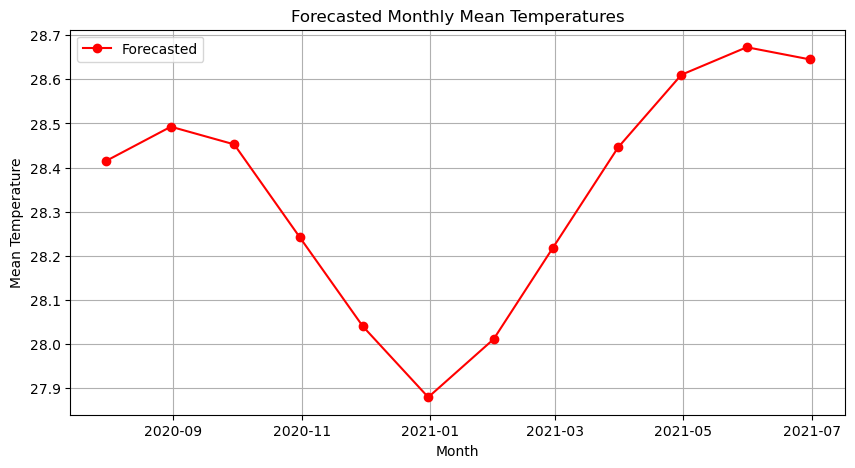

In [14]:
# Take last 12 months data for forecasting
last_12_months = scaled_data[-look_back:].reshape(1, look_back, 1)

# Predict future months
future_preds = []
num_months = 12  # Forecast for next 12 months

for _ in range(num_months):
    pred = model.predict(last_12_months)  # Predict next value
    future_preds.append(pred[0][0])  
    
    # Reshape pred correctly before appending
    pred_reshaped = np.array(pred).reshape(1, 1, 1)  
    
    # Append prediction and remove first element (rolling window)
    last_12_months = np.append(last_12_months[:, 1:, :], pred_reshaped, axis=1)

# Inverse transform predictions
future_preds_inv = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# Generate future dates
future_dates = pd.date_range(start=df.index.max(), periods=num_months + 1, freq='M')[1:]

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(future_dates, future_preds_inv, marker='o', linestyle='-', color='red', label='Forecasted')
plt.title("Forecasted Monthly Mean Temperatures")
plt.xlabel("Month")
plt.ylabel("Mean Temperature")
plt.legend()
plt.grid()
plt.show()


In [15]:
print(future_preds_inv)

[[28.414293]
 [28.492619]
 [28.452526]
 [28.242414]
 [28.039724]
 [27.87898 ]
 [28.010708]
 [28.217289]
 [28.44556 ]
 [28.61039 ]
 [28.672895]
 [28.645197]]


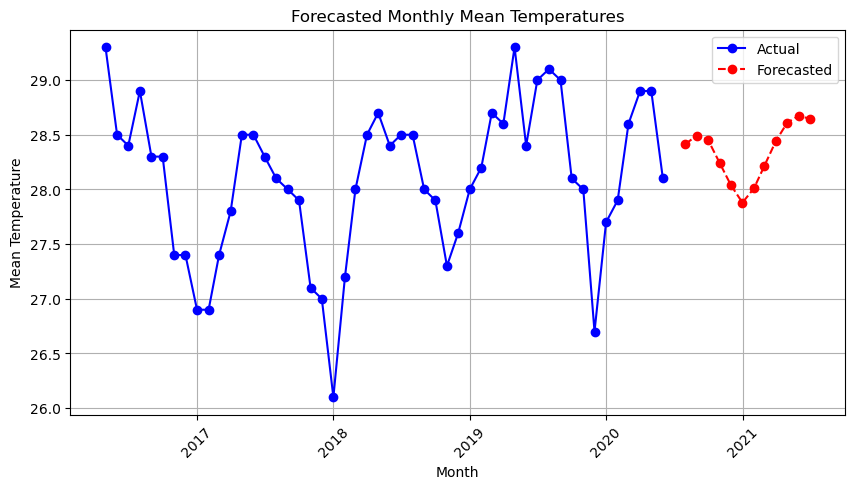

In [16]:
# Future dates generate
future_dates = pd.date_range(start=df.index.max(), periods=len(future_preds_inv)+1, freq='M')[1:]

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(df.index[-50:], df['mean_temp'].values[-50:], marker='o', linestyle='-', label='Actual', color='blue')
plt.plot(future_dates, future_preds_inv, marker='o', linestyle='--', label='Forecasted', color='red')

# Labels & Legend
plt.title("Forecasted Monthly Mean Temperatures")
plt.xlabel("Month")
plt.ylabel("Mean Temperature")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()


In [17]:
# Assuming  real validation data for comparison
true_values = df['mean_temp'].values[-12:]  # Last 12 real values for validation

# Calculate MAE & RMSE
mae = mean_absolute_error(true_values, future_preds_inv)
rmse = np.sqrt(mean_squared_error(true_values, future_preds_inv))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Absolute Error (MAE): 0.41
Root Mean Squared Error (RMSE): 0.51
